# Assignment 4: Block Matching and Harris Corner Detection
## Ex. 4.1 Dense Optical Flow by Block Matching
* implement the block matching method as shown in the lecture
* take two frames from the datasets "lane_detection" or "racecar" with variable distances in time (1, 2, x) and compute the vector flow field
* display a subset of flow vectors on the gray-value version of the first image, by drawing a respective line. adjust the grid density such that not too many vectors overlap (**RESULT**)

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color, filters
import cv2
import numpy as np

def mse(aoi1, aoi2):
    height, width = aoi1.shape
    res = 0
    for y in range(0, height):
        for x in range(0, width):
            res += (aoi1[y, x] - aoi2[y, x]) ** 2
    return res


def mse_rgb(aoi1, aoi2):
    height, width, colors = aoi1.shape
    res = 0
    for y in range(0, height):
        for x in range(0, width):
            for c in range(0, colors):
                res += (aoi1[y, x, c] - aoi2[y, x, c]) ** 2
    return res


# Find first squared error within treshold and return it
# aoi to find, image to search in, search window size, origin of aoi (x and y), treshold
def matchAoi(aoi, image, ws, aoiX, aoiY, threshold):
    aoiHeight, aoiWidth, _ = aoi.shape

    if aoiHeight == 0 or aoiWidth == 0:
        print("AOI!")

    halfAoiWidth = int(np.floor(aoiWidth / 2))
    halfAoiHeight = int(np.floor(aoiHeight / 2))

    height, width, _ = image.shape

    candidates = dict()

    # iterate through window
    for y in range(aoiY - ws, aoiY + ws):
        for x in range(aoiX - ws, aoiX + ws):
            minY = y - halfAoiHeight
            maxY = y + halfAoiHeight

            minX = x - halfAoiWidth
            maxX = x + halfAoiWidth

            # continue if aoi would be out of range of image
            if 0 > minY or maxY > height - 1:
                continue

            if 0 > minX or maxX > width - 1:
                continue

            # print(minY, maxY, minX, maxX)
            squaredError = mse_rgb(aoi, image[minY:maxY, minX:maxX])
            # print(squaredError)

            if squaredError < threshold:
                candidates[squaredError] = (x,y)
    
    if len(candidates) == 0:
        return None, None, None
    else:  
        #find min difference (res is (score, (x, y))
        res = min(candidates.items(), key=lambda x:x[1])
        squaredError = res[0]
        targetX = res[1][0]
        targetY = res[1][1]
        print("Found: ({},{}) --> ({},{})".format(aoiX, aoiY, targetX, targetY))
        return targetX, targetY, squaredError
    


# ws is the area to compare
def blockMatching(image1, image2, ws, threshold):
    print("B L O C K   M A T C H I N G . . . ")

    height, width, _ = image1.shape

    originToTarget = dict()

    step = 30
    rows = ((height - (2*ws)) // step) 
    cols = ((width - (2*ws)) // step)
    total = rows * cols
    
    print("Total: {}, R: {}, C: {}, WS: {}, Shape: h:{} w:{}".format(total, rows, cols, ws, height, width))
    current = 0

    for y in range(ws, height - ws, step):
        for x in range(ws, width - ws, step):
            current += 1
            if (current % 5) == 0:
                print("Progress: {}".format(current/total*100))

            aoi0 = image1[y - ws:y + ws, x - ws:x + ws]
            matchX, matchY, _ = matchAoi(aoi0, image2, 50, x, y, threshold)
            if matchX is not None and matchY is not None:
                originToTarget[(y, x)] = (matchY, matchX)

    return originToTarget


def drawArrows(image, indicators):
    plt.imshow(image)
    tmpImage = np.copy(image)
    # for key, val in indicators:
    for key in indicators:
        val = indicators[key]
        # print("Found: ({},{}) --> ({},{})".format(val[1], val[0], key[1], key[0]))
        # plt.arrow(float(val[1]), float(val[0]), float(key[1] - val[1]), float(key[0] - val[0]), head_width=0.05, head_length=0.1, fc='k',ec='k', facecolor="red")
        cv2.arrowedLine(tmpImage, (key[1], key[0]), (val[1], val[0]), (0, 0, 255))

    return tmpImage



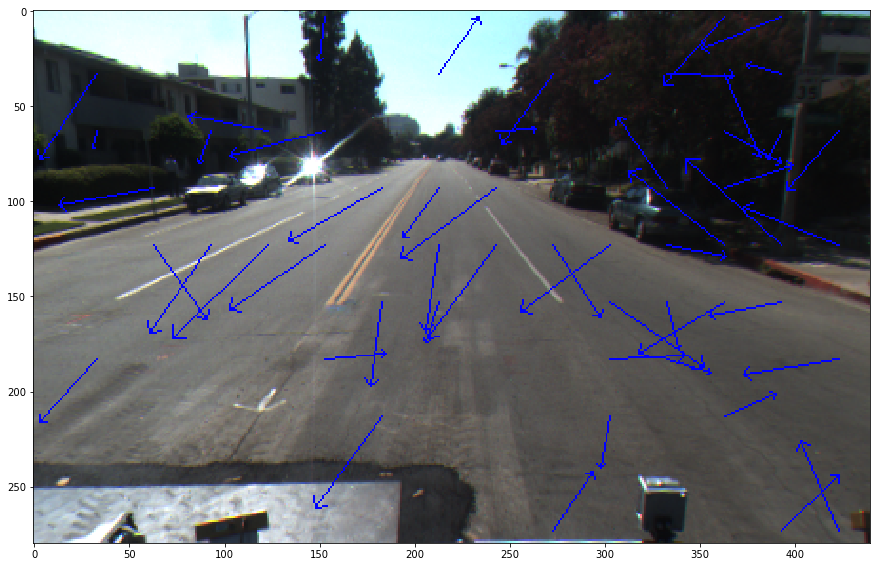

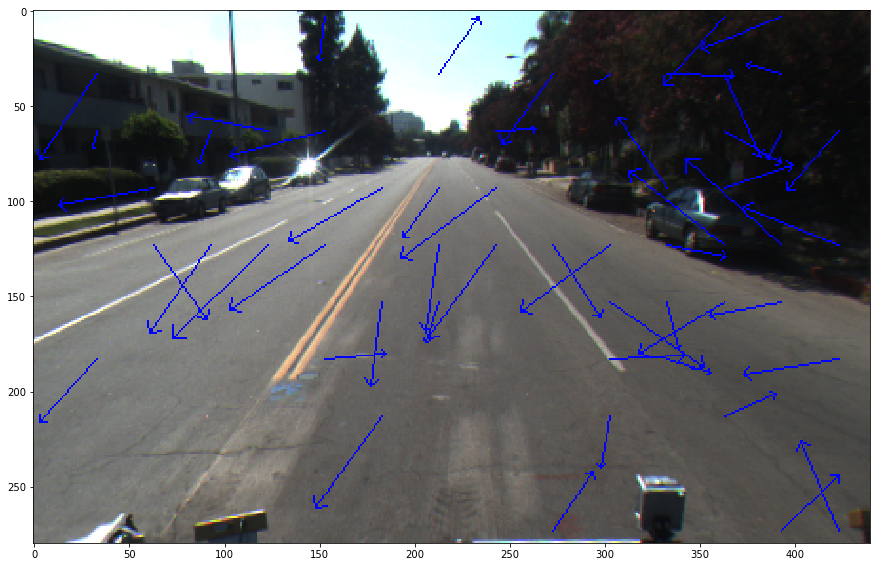

In [69]:
# chose other images if you like
lane1 = io.imread('images/lane_detection/f00000.png')
lane2 = io.imread('images/lane_detection/f00001.png')

height, width, _ = lane1.shape
lane1 = lane1[100:height-100, 100:width-100]
lane2 = lane2[100:height-100, 100:width-100]

# res = blockMatching(color.rgb2grey(lane1), color.rgb2grey(lane2), 5, 0.01)
res = blockMatching(lane1, lane2, 3, 10000)
print(len(res))


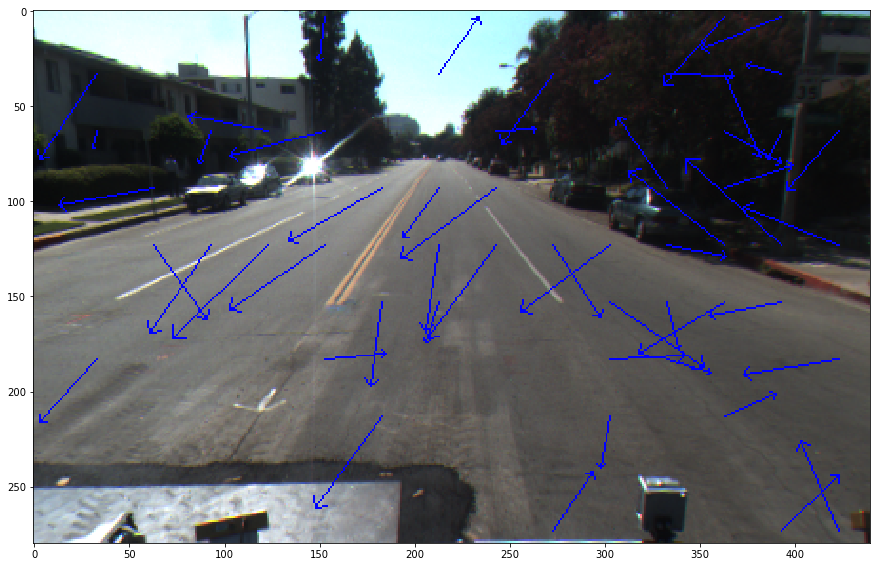

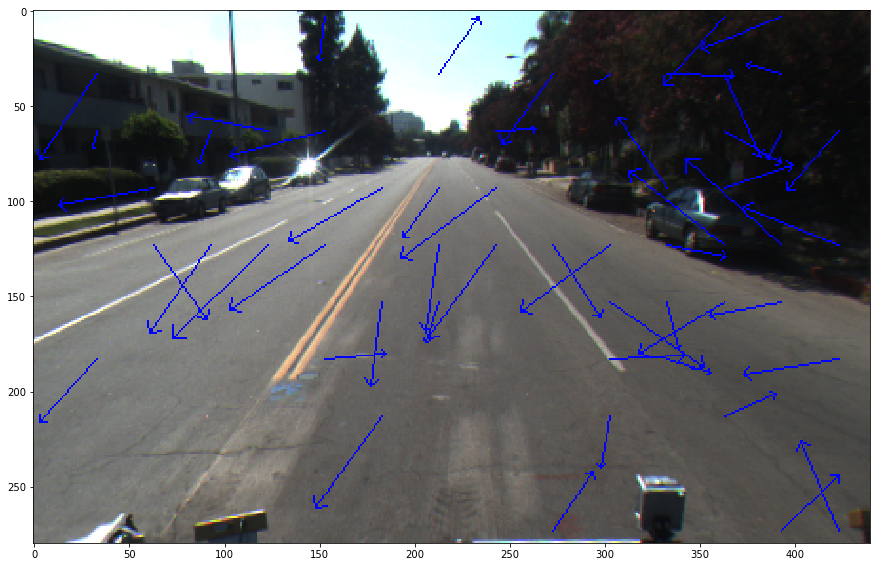

In [74]:

plt.figure(0, figsize=(15,10))
im0 = drawArrows(lane1, res)
plt.imshow(im0)

plt.figure(1, figsize=(15,10))
im1 = drawArrows(lane2, res)
plt.imshow(im1)

plt.figure(2, figsize=(15,10))
plt.imshow(lane1)

plt.show()



## Ex. 4.2 Harris Corner Detection
* implement the Harris Corner Detector as discussed in the lecture
* compute corners in the first image and track them with Lucas-Kanade (use e.g. the function "calcOpticalFlowPyrLK" in OpenCV)
* mark the positions of your Harris corners and draw the flow vectors found by Lucas-Kanade on the gray-value versions of the first image (**RESULT**)

In [22]:
def nonMaxSuppression(edges, ws):
    height, width = edges.shape
    
    #suppressed = edges
    suppressed = np.ones_like(edges)
    
    for x in range(1, width):
        for y in range(1, height):
            # suppressed[y,x] = 1 
            
            if np.sum(edges[y-1:y+1, x-1:x+1]) <= 0:
                suppressed[y,x] = 0
                continue
            
            # horizontal
            if edges[y, x-1] > edges[y, x] or edges[y, x+1] > edges[y,x]:
                suppressed[y,x] = 0
            
            # vertical 
            if edges[y-1,x] > edges[y,x] or edges[y+1,x] > edges[y,x]:
                suppressed[y,x] = 0
        
            # diagnoal
            if edges[y-1,x-1] > edges[y,x] or edges[y+1,x+1] > edges[y,x]:
                suppressed[y,x] = 0
                
            # diagnoal
            if edges[y-1,x+1] > edges[y,x] or edges[y+1,x-1] > edges[y,x]:
                suppressed[y,x] = 0
        
    return suppressed


def harrisCorner(image, ws=1):
    imgGrey = color.rgb2grey(image)
    height, width = imgGrey.shape
    
    ix = filters.sobel_h(imgGrey)
    iy = filters.sobel_v(imgGrey)
    
    edges = np.zeros_like(imgGrey)
    
    # mult at each pixel
    ix2 = ix * ix
    iy2 = iy * iy
    ixy = ix * iy
    
    for x in range(ws, width-ws):
        for y in range(ws, height-ws):            
            sx2 = np.sum(ix2[y-ws:y+ws, x-ws:x+ws])
            sy2 = np.sum(iy2[y-ws:y+ws, x-ws:x+ws])
            sxy = np.sum(ixy[y-ws:y+ws, x-ws:x+ws])
            H = np.array( [ [sx2, sxy], [sxy, sy2] ] )
            R = np.linalg.det(H) - (0.04*np.power(np.matrix.trace(H), 2))
            
            edges[y,x] = R if R > 0.005 else 0  #1 if R > 0.005 else 0
            
    return nonMaxSuppression(edges, ws)
    # return edges


def getPointVector(greyScaleImage):
    height, width = greyScaleImage.shape
    points = []
    p0=np.array([[348.0, 251.0]],np.float32)
    for x in range(1, width):
        for y in range(1, height):
            if greyScaleImage[y,x] == 1.0:
                points.append([np.float32(x),np.float32(y)])
    
    # print(points)
    return np.array(points, np.float32)



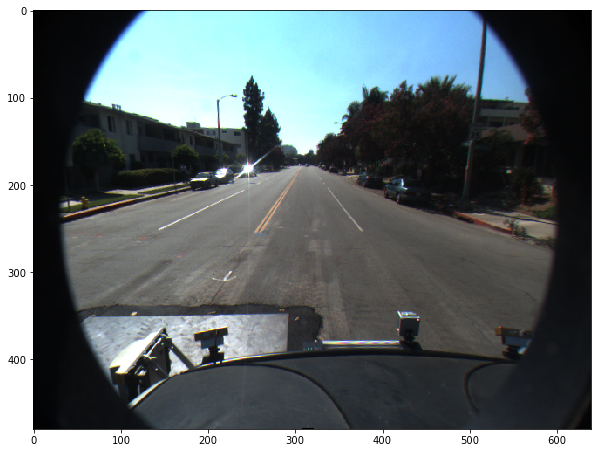

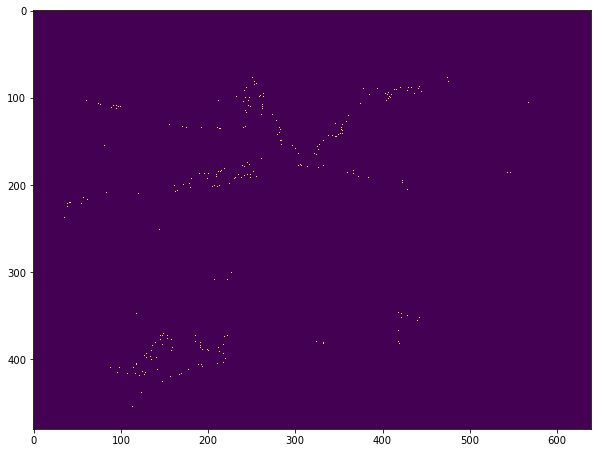

In [10]:
l1 = io.imread('images/lane_detection/f00000.png')
l2 = io.imread('images/lane_detection/f00001.png')

l1Height, l1Width, _ = l1.shape

crop = 50
# l1 = l1[crop:l1Height-crop, crop:l1Width-crop]
# l2 = l2[crop:l1Height-crop, crop:l1Width-crop]

# ref = io.imread('images/reference.png')

res = harrisCorner(l1)

plt.figure(1, figsize=(10, 15))
plt.imshow(l1)

plt.figure(2, figsize=(10, 15))
plt.imshow(res)

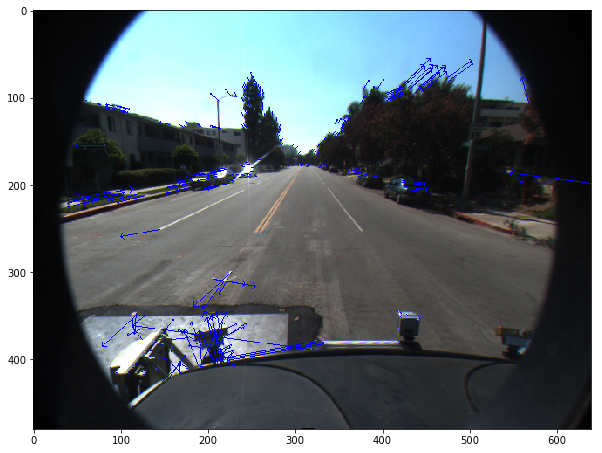

In [6]:
def drawVectors(img, oldPoints, newPoints):
    for i in range (0, len(oldPoints)):
        oldPoint = oldPoints[i]
        newPoint = newPoints[i]
        
        cv2.arrowedLine(img, (oldPoint[0], oldPoint[1]), (newPoint[0], newPoint[1]), (0,0,255))
    return img


points = getPointVector(res)
# nextPoints, _, _ = cv2.calcOpticalFlowPyrLK(l1, l2, points, None, winSize=(50,50))
nextPoints, _, _ = cv2.calcOpticalFlowPyrLK(l1, l2, points, None)

resultImage1 = np.copy(l1)
resultImage1 = drawVectors(resultImage1, points, nextPoints)

resultImage2 = np.copy(l2)
resultImage2 = drawVectors(resultImage2, points, nextPoints)

plt.figure(1, figsize=(10, 15))
plt.imshow(resultImage1)

plt.figure(2, figsize=(10, 15))
plt.imshow(resultImage2)
